# Getting Data

In [1]:
from setup_and_validation import download_data, validate_data
import polars as pl
import matplotlib.pyplot as plt

In [2]:
URL_DATA = 'https://storage.data.gov.my/healthcare/blood_donations_state.parquet'
df = download_data(URL_DATA)
df.head()


date,state,blood_type,donations
date,str,str,i64
2006-01-01,"""Johor""","""all""",87
2006-01-02,"""Johor""","""all""",15
2006-01-03,"""Johor""","""all""",8
2006-01-04,"""Johor""","""all""",33
2006-01-05,"""Johor""","""all""",20


In [3]:
validate_data(df)

All rows have been validated successfully.
No duplicated rows detected.


In [4]:
print(f"We have {df.height} rows. Let's check the contents.")

We have 458705 rows. Let's check the contents.


In [5]:
print(f"Number of days: {df['date'].n_unique()}")
print(f"Number of blood types: {df['blood_type'].n_unique()}")
print(f"Number of states: {df['state'].n_unique()}")

Number of days: 7057
Number of blood types: 5
Number of states: 13


In [6]:
assert df.height == df['date'].n_unique() * df['blood_type'].n_unique() * df['state'].n_unique()

Now, we could confirm that we have exactly one row per date, state , and blood type combination.

In [7]:
# We have the 'all' column which should be exactly equal to the sum of the four blood types. Let's check this! 

grouped_df = df.filter(pl.col('blood_type') != 'all').group_by(['state', 'date']).agg(pl.col('donations').sum())
df_all = df.filter(pl.col('blood_type') == 'all')
comp_df = df_all.join(grouped_df, on=['date', 'state'], how='inner').with_columns((pl.col('donations') - pl.col('donations_right')).alias('diff'))

diff_df = comp_df.filter(pl.col('diff') != 0)
diff_df

date,state,blood_type,donations,donations_right,diff
date,str,str,i64,i64,i64
2021-09-21,"""W.P. Kuala Lumpur""","""all""",349,348,1
2012-07-13,"""W.P. Kuala Lumpur""","""all""",783,782,1
2019-12-24,"""W.P. Kuala Lumpur""","""all""",199,198,1
2024-06-21,"""W.P. Kuala Lumpur""","""all""",504,503,1
2025-01-14,"""W.P. Kuala Lumpur""","""all""",551,550,1
…,…,…,…,…,…
2011-10-26,"""W.P. Kuala Lumpur""","""all""",235,234,1
2014-06-21,"""W.P. Kuala Lumpur""","""all""",874,873,1
2023-12-14,"""W.P. Kuala Lumpur""","""all""",517,516,1


It seems that 217 rows have mismatches, we can further check how 'severe' these mismatches are.

In [8]:
print(diff_df['diff'].max())
print(diff_df['diff'].min())


3
1


In [9]:
# Differences seem not too bad, but let's check
diff_df.sort('diff', descending=True)

date,state,blood_type,donations,donations_right,diff
date,str,str,i64,i64,i64
2022-09-15,"""W.P. Kuala Lumpur""","""all""",577,574,3
2013-06-08,"""W.P. Kuala Lumpur""","""all""",155,153,2
2022-06-19,"""W.P. Kuala Lumpur""","""all""",939,937,2
2007-10-30,"""W.P. Kuala Lumpur""","""all""",445,443,2
2019-07-08,"""W.P. Kuala Lumpur""","""all""",402,400,2
…,…,…,…,…,…
2011-10-26,"""W.P. Kuala Lumpur""","""all""",235,234,1
2014-06-21,"""W.P. Kuala Lumpur""","""all""",874,873,1
2023-12-14,"""W.P. Kuala Lumpur""","""all""",517,516,1


We see some differences / data issues. However, in the grand scheme of thigns are are relatively minor and we can just replace the 'all' column with a sum of the other values.

In [10]:
# We regroup this by pivoting the table
df = df.pivot(
    values="donations",
    index=["date", "state"],
    on="blood_type"
).drop('all')
df

date,state,a,b,o,ab
date,str,i64,i64,i64,i64
2006-01-01,"""Johor""",19,20,45,3
2006-01-02,"""Johor""",4,3,6,2
2006-01-03,"""Johor""",2,2,4,0
2006-01-04,"""Johor""",7,11,12,3
2006-01-05,"""Johor""",3,8,8,1
…,…,…,…,…,…
2025-04-23,"""W.P. Kuala Lumpur""",141,144,235,24
2025-04-24,"""W.P. Kuala Lumpur""",151,180,238,32
2025-04-25,"""W.P. Kuala Lumpur""",122,121,205,31


In [11]:
df = df.with_columns(pl.sum_horizontal(["a", "b", "o", "ab"]).alias("all"))
df

date,state,a,b,o,ab,all
date,str,i64,i64,i64,i64,i64
2006-01-01,"""Johor""",19,20,45,3,87
2006-01-02,"""Johor""",4,3,6,2,15
2006-01-03,"""Johor""",2,2,4,0,8
2006-01-04,"""Johor""",7,11,12,3,33
2006-01-05,"""Johor""",3,8,8,1,20
…,…,…,…,…,…,…
2025-04-23,"""W.P. Kuala Lumpur""",141,144,235,24,544
2025-04-24,"""W.P. Kuala Lumpur""",151,180,238,32,601
2025-04-25,"""W.P. Kuala Lumpur""",122,121,205,31,479


# Visualization

For the time being, we will drop the 'state' column and look at the nationwide level.

In [12]:
df_all = df.group_by(pl.col('date')).sum().drop('state').sort('date')
df_all

date,a,b,o,ab,all
date,i64,i64,i64,i64,i64
2006-01-01,152,139,194,40,525
2006-01-02,53,43,112,19,227
2006-01-03,29,21,56,6,112
2006-01-04,92,98,165,36,391
2006-01-05,149,198,193,42,582
…,…,…,…,…,…
2025-04-23,438,491,733,116,1778
2025-04-24,357,392,600,76,1425
2025-04-25,412,416,690,89,1607


In [13]:
# For visualization, we group this by week.
# Otherwise, the outcome plots cannot really show the line difference

df_weekly = (
    df_all
    .with_columns(
        [
            pl.col('date').dt.week().alias('week'),
            pl.col('date').dt.year().alias('year')
        ]
    ).group_by(['year', 'week']).sum()
    .sort('year', 'week')
    .drop('date')
    .with_columns(pl.concat_str(pl.col('year'), pl.col('week'), separator = '-')
    .alias('yearweek'))
)

df_weekly

year,week,a,b,o,ab,all,yearweek
i32,i8,i64,i64,i64,i64,i64,str
2006,1,664,678,1013,194,2549,"""2006-1"""
2006,2,747,785,1181,183,2896,"""2006-2"""
2006,3,1322,1439,2138,323,5222,"""2006-3"""
2006,4,954,1038,1475,241,3708,"""2006-4"""
2006,5,416,481,751,118,1766,"""2006-5"""
…,…,…,…,…,…,…,…
2025,13,1887,2023,3386,396,7692,"""2025-13"""
2025,14,2130,2294,3729,500,8653,"""2025-14"""
2025,15,3021,3206,5140,738,12105,"""2025-15"""


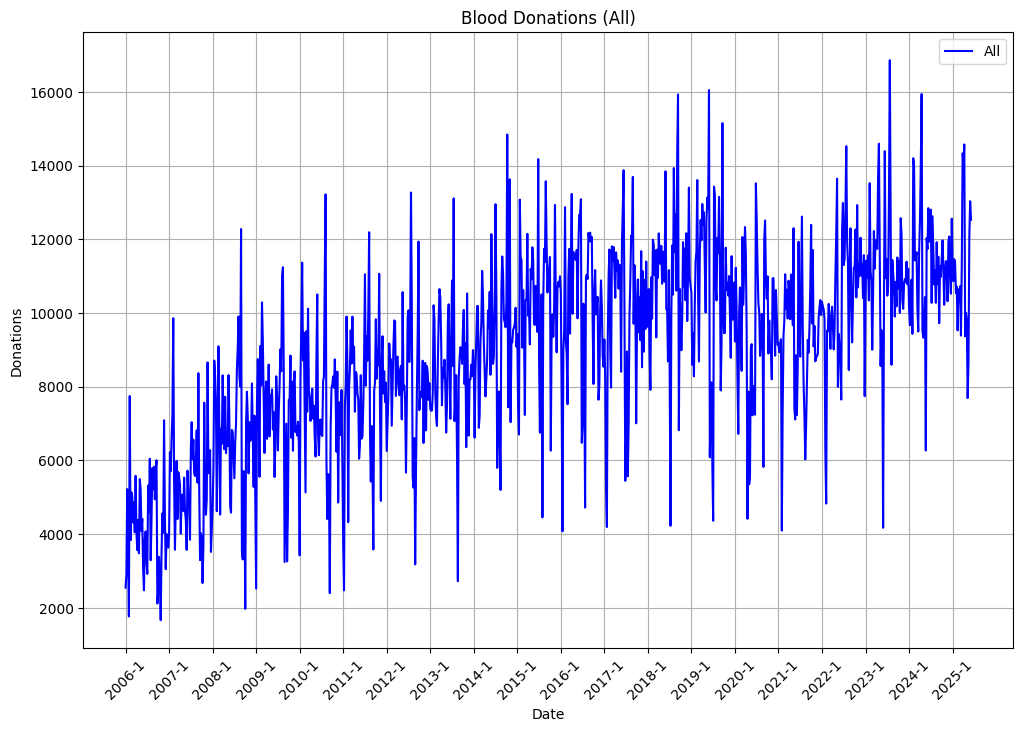

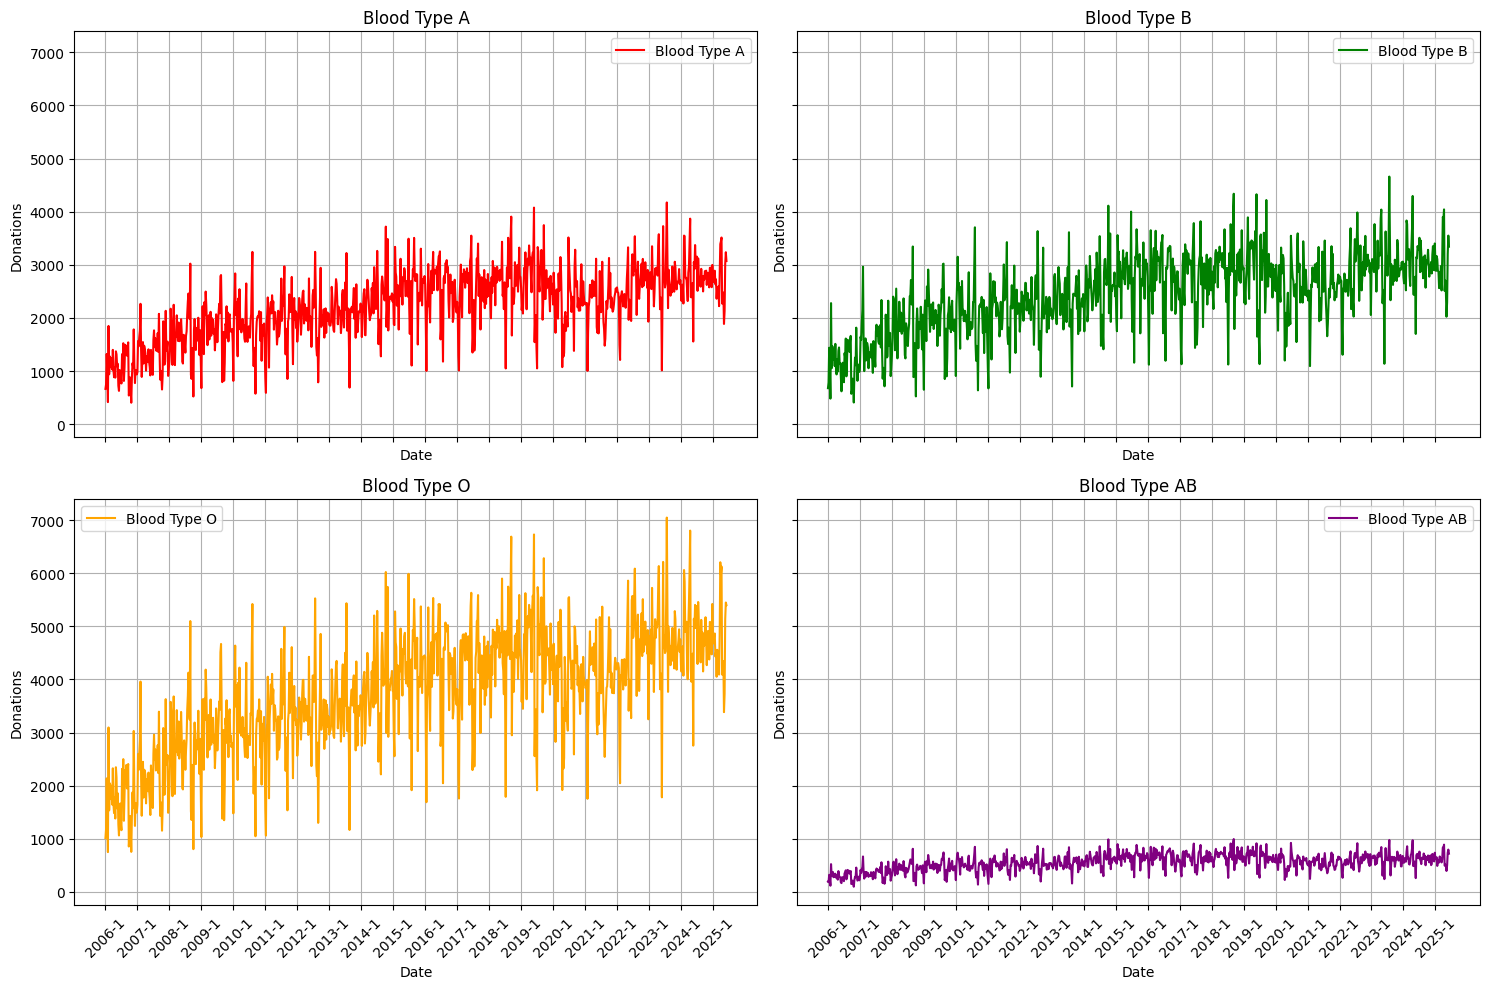

In [14]:
# Plot for the 'all' column
plt.figure(figsize=(12, 8))
plt.plot(df_weekly['yearweek'], df_weekly['all'], label='All', color='blue')
plt.title('Blood Donations (All)')
plt.xlabel('Date')
plt.ylabel('Donations')
plt.legend()
plt.grid()

# Set x-axis ticks to the first week of each year
year_ticks = df_weekly.filter(pl.col('week') == 1)['yearweek']
plt.xticks(ticks=range(0, len(df_weekly['yearweek']), 52),  # Approximate yearly interval
           labels=year_ticks, rotation=45)  # Rotate for readability

plt.show()

# 2x2 plot for 'a', 'b', 'o', and 'ab' columns
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

columns = ['a', 'b', 'o', 'ab']
titles = ['Blood Type A', 'Blood Type B', 'Blood Type O', 'Blood Type AB']
colors = ['red', 'green', 'orange', 'purple']

for i, ax in enumerate(axes.flat):
    ax.plot(df_weekly['yearweek'], df_weekly[columns[i]], label=titles[i], color=colors[i])
    ax.set_title(titles[i])
    ax.set_xlabel('Date')
    ax.set_ylabel('Donations')
    ax.legend()
    ax.grid()

    # Set x-axis ticks to the first week of each year
    ax.set_xticks(range(0, len(df_weekly['yearweek']), 52))  # Approximate yearly interval
    ax.set_xticklabels(year_ticks, rotation=45)  # Rotate for readability

plt.tight_layout()
plt.show()

Some interesting facts we can already tell from here: 
- Across all blood types and overall, we see already an increasing trend
- We see some seasonality, some ups and downs
- Blood type O is always highest, whereas AB is always lower (which makes sense given the prevalence)


In [15]:
df.filter(pl.col('state') == 'Kedah')['all'].sum()

804243

In [16]:
# df.filter(pl.col('state') == "Kedah") #.group_by('state').sum()['all'][0]

In [26]:
corrmatrix

a,b,o,ab
f64,f64,f64,f64
1.0,0.945163,0.960829,0.829434
0.945163,1.0,0.95414,0.83114
0.960829,0.95414,1.0,0.830331
0.829434,0.83114,0.830331,1.0


In [30]:
# Correlation matrices

corr_a_b = []
corr_a_ab = []
corr_a_o = []
corr_b_ab = []
corr_b_o = []
corr_ab_o = []
total_pop = []
states = []


for elem in df['state'].unique():
    total_donations = df.filter(pl.col('state') == elem)['all'].sum()
    print(f"{elem}: {total_donations} total donations.")
    corrmatrix = df.filter(df['state'] == elem).select(['a', 'b', 'o', 'ab']).corr()
    print(corrmatrix)
    
    states.append(elem)
    corr_a_b.append(corrmatrix[0, 1])
    corr_a_ab.append(corrmatrix[0, 2])
    corr_a_o.append(corrmatrix[0, 3])
    corr_b_ab.append(corrmatrix[1, 2])
    corr_b_o.append(corrmatrix[1, 3])
    corr_ab_o.append(corrmatrix[2,3])
    total_pop.append(total_donations)
    
    print("\n")

Sarawak: 519587 total donations.
shape: (4, 4)
┌──────────┬──────────┬──────────┬──────────┐
│ a        ┆ b        ┆ o        ┆ ab       │
│ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╡
│ 1.0      ┆ 0.938565 ┆ 0.949936 ┆ 0.876716 │
│ 0.938565 ┆ 1.0      ┆ 0.953055 ┆ 0.88008  │
│ 0.949936 ┆ 0.953055 ┆ 1.0      ┆ 0.882389 │
│ 0.876716 ┆ 0.88008  ┆ 0.882389 ┆ 1.0      │
└──────────┴──────────┴──────────┴──────────┘


Johor: 627717 total donations.
shape: (4, 4)
┌──────────┬──────────┬──────────┬──────────┐
│ a        ┆ b        ┆ o        ┆ ab       │
│ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╡
│ 1.0      ┆ 0.945163 ┆ 0.960829 ┆ 0.829434 │
│ 0.945163 ┆ 1.0      ┆ 0.95414  ┆ 0.83114  │
│ 0.960829 ┆ 0.95414  ┆ 1.0      ┆ 0.830331 │
│ 0.829434 ┆ 0.83114  ┆ 0.830331 ┆ 1.0      │
└──────────┴──────────┴─────────

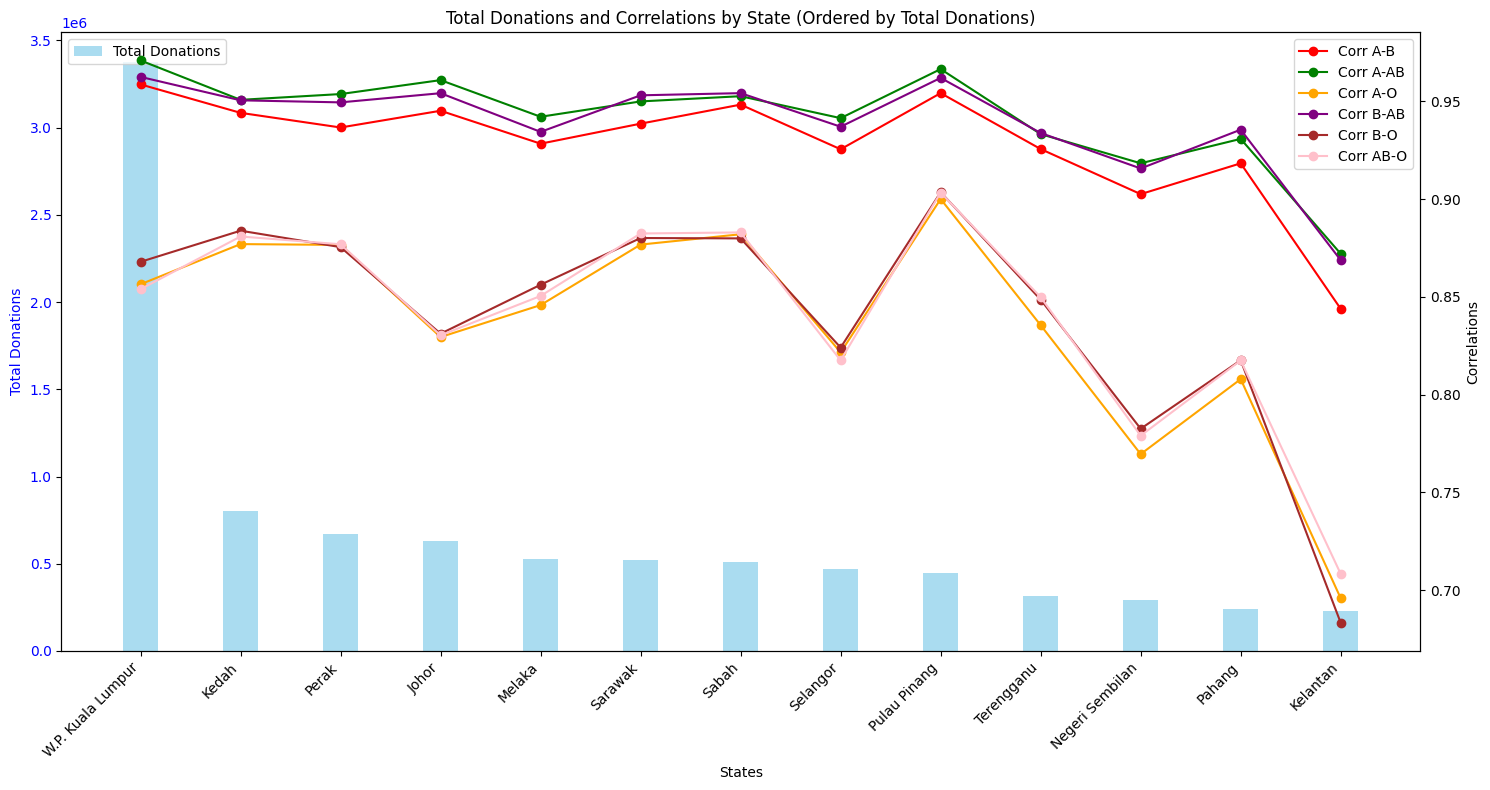

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Sort states and total_pop based on total_pop in descending order
sorted_indices = np.argsort(total_pop)[::-1]
states_sorted = [states[i] for i in sorted_indices]
total_pop_sorted = [total_pop[i] for i in sorted_indices]
corr_a_b_sorted = [corr_a_b[i] for i in sorted_indices]
corr_a_ab_sorted = [corr_a_ab[i] for i in sorted_indices]
corr_a_o_sorted = [corr_a_o[i] for i in sorted_indices]
corr_b_ab_sorted = [corr_b_ab[i] for i in sorted_indices]
corr_b_o_sorted = [corr_b_o[i] for i in sorted_indices]
corr_ab_o_sorted = [corr_ab_o[i] for i in sorted_indices]

# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(15, 8))

# Bar plot for total donations
bar_width = 0.35
x = np.arange(len(states_sorted))
ax1.bar(x, total_pop_sorted, bar_width, label='Total Donations', color='skyblue', alpha=0.7)
ax1.set_xlabel('States')
ax1.set_ylabel('Total Donations', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(x)
ax1.set_xticklabels(states_sorted, rotation=45, ha='right')

# Line plot for correlations
ax2 = ax1.twinx()
ax2.plot(x, corr_a_b_sorted, label='Corr A-B', marker='o', color='red')
ax2.plot(x, corr_a_ab_sorted, label='Corr A-AB', marker='o', color='green')
ax2.plot(x, corr_a_o_sorted, label='Corr A-O', marker='o', color='orange')
ax2.plot(x, corr_b_ab_sorted, label='Corr B-AB', marker='o', color='purple')
ax2.plot(x, corr_b_o_sorted, label='Corr B-O', marker='o', color='brown')
ax2.plot(x, corr_ab_o_sorted, label='Corr AB-O', marker='o', color='pink')
ax2.set_ylabel('Correlations', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add a title
plt.title('Total Donations and Correlations by State (Ordered by Total Donations)')

# Show the plot
plt.tight_layout()
plt.show()

In [25]:
corrmatrix[0,2]

0.9608285116055363

In [ ]:
corr_a_b 

KeyboardInterrupt: 

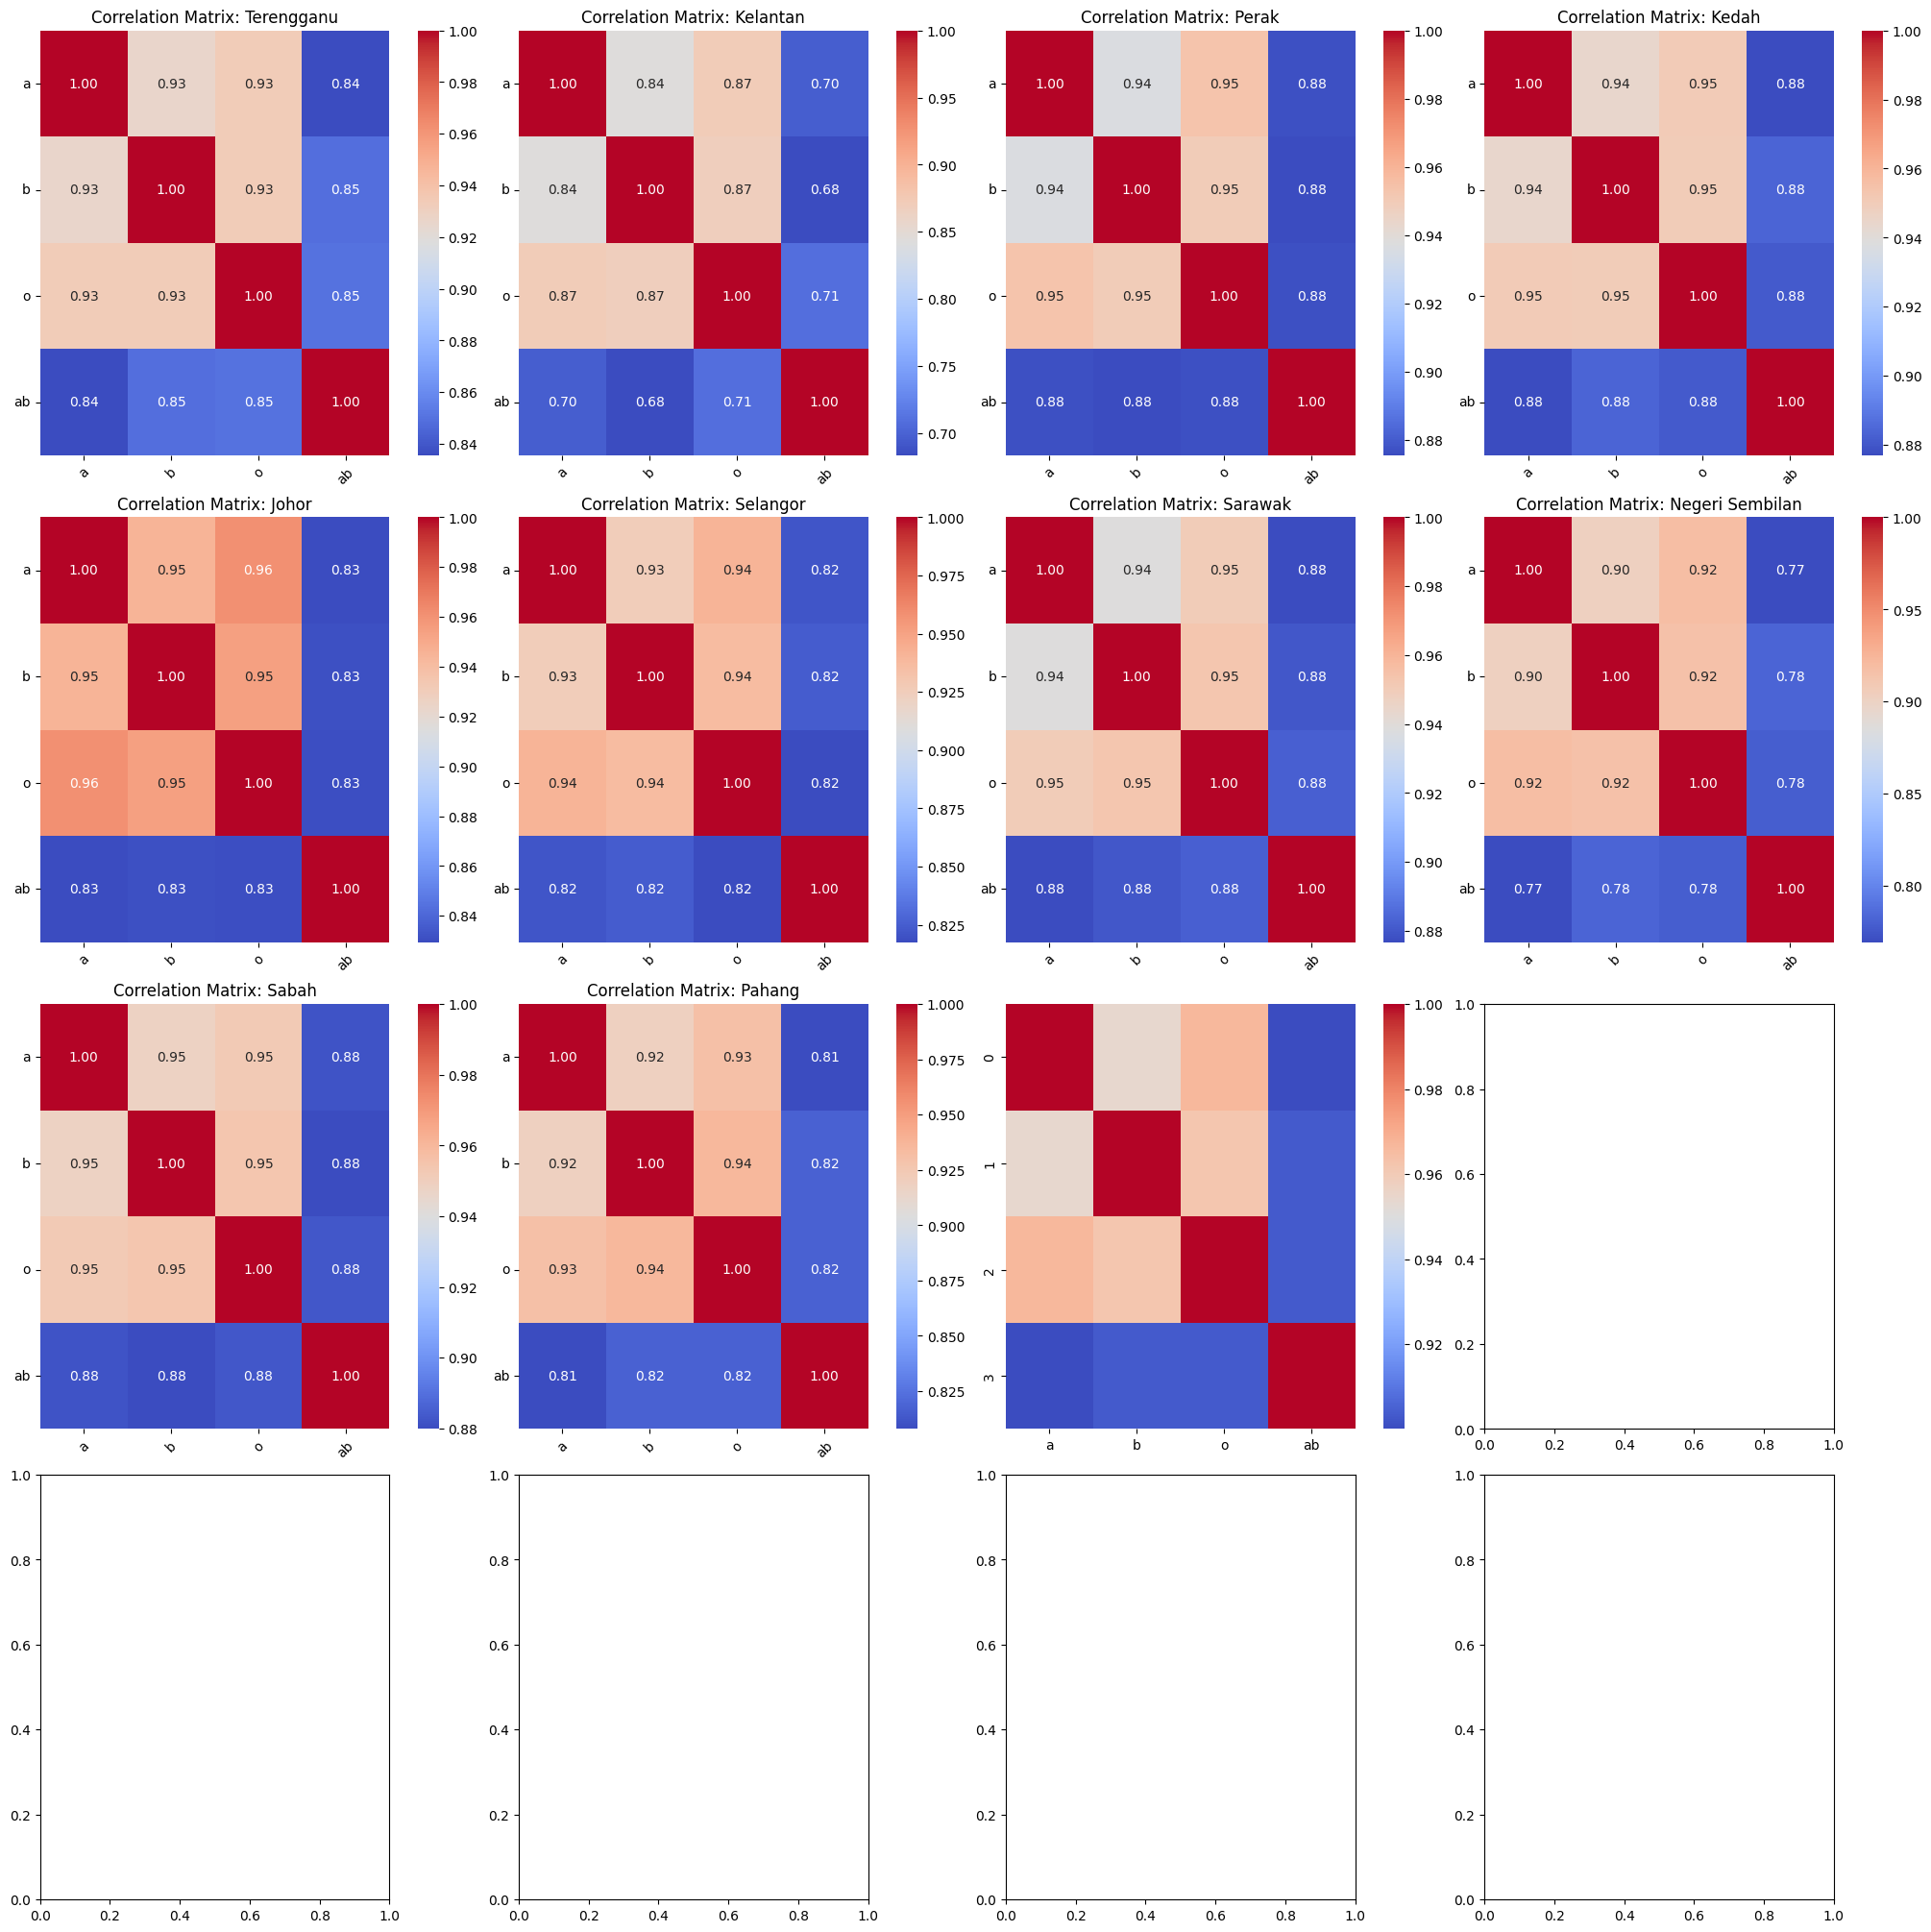

In [21]:
import seaborn as sns

# Visualize all correlation matrices for each state
import matplotlib.pyplot as plt

# Number of states
num_states = len(corr_dicts)

# Determine grid size for subplots
cols = 4  # Number of columns in the grid
rows = (num_states + cols - 1) // cols  # Calculate rows needed

# Create a figure for the grid of heatmaps
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5), constrained_layout=True)

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot each state's correlation matrix as a heatmap
for idx, (state, correlation_matrix) in enumerate(state_correlation_matrices.items()):
    sns.heatmap(
        correlation_matrix.to_pandas(),
        annot=True,
        cmap='coolwarm',
        fmt=".2f",
        ax=axes[idx]
    )
    axes[idx].set_title(f"Correlation Matrix: {state}")
    axes[idx].set_xticklabels(correlation_matrix.columns, rotation=45)
    axes[idx].set_yticklabels(correlation_matrix.columns, rotation=0)

# Hide any unused subplots
for idx in range(num_states, len(axes)):
    axes[idx].axis('off')

plt.show()

Correlation Matrix for Terengganu:
shape: (4, 4)
┌──────────┬──────────┬──────────┬──────────┐
│ a        ┆ b        ┆ o        ┆ ab       │
│ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╡
│ 1.0      ┆ 0.925575 ┆ 0.93322  ┆ 0.835493 │
│ 0.925575 ┆ 1.0      ┆ 0.933794 ┆ 0.848566 │
│ 0.93322  ┆ 0.933794 ┆ 1.0      ┆ 0.849832 │
│ 0.835493 ┆ 0.848566 ┆ 0.849832 ┆ 1.0      │
└──────────┴──────────┴──────────┴──────────┘


Correlation Matrix for Kelantan:
shape: (4, 4)
┌──────────┬──────────┬──────────┬──────────┐
│ a        ┆ b        ┆ o        ┆ ab       │
│ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╡
│ 1.0      ┆ 0.84386  ┆ 0.872023 ┆ 0.695824 │
│ 0.84386  ┆ 1.0      ┆ 0.868747 ┆ 0.683284 │
│ 0.872023 ┆ 0.868747 ┆ 1.0      ┆ 0.708289 │
│ 0.695824 ┆ 0.683284 ┆ 0.708289 ┆ 1.0      │
└──────────┴──────────┴─────

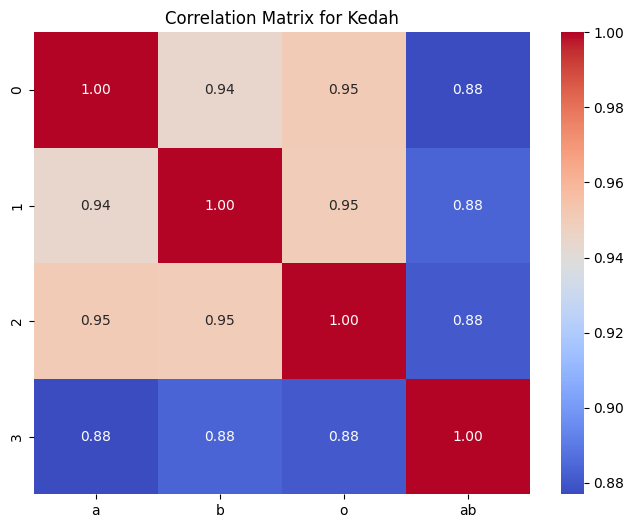

In [18]:
import seaborn as sns

# Group the data by state and calculate the correlation matrix for each state
states = df['state'].unique()
state_correlation_matrices = {}

for state in states:
    state_data = df.filter(pl.col('state') == state).select(['a', 'b', 'o', 'ab'])
    state_correlation_matrices[state] = state_data.corr()

# Display the correlation matrices for each state
for state, correlation_matrix in state_correlation_matrices.items():
    print(f"Correlation Matrix for {state}:")
    print(correlation_matrix)
    print("\n")

# Optionally, you can visualize the correlation matrix for a specific state

state_to_visualize = 'Kedah'  # Change this to the state you want to visualize
if state_to_visualize in state_correlation_matrices:
    plt.figure(figsize=(8, 6))
    sns.heatmap(state_correlation_matrices[state_to_visualize].to_pandas(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"Correlation Matrix for {state_to_visualize}")
    plt.show()

Nothing really standing out here

In [22]:
df

date,state,all,a,b,o,ab
date,str,i64,i64,i64,i64,i64
2006-01-01,"""Johor""",87,19,20,45,3
2006-01-02,"""Johor""",15,4,3,6,2
2006-01-03,"""Johor""",8,2,2,4,0
2006-01-04,"""Johor""",33,7,11,12,3
2006-01-05,"""Johor""",20,3,8,8,1
…,…,…,…,…,…,…
2025-04-23,"""W.P. Kuala Lumpur""",544,141,144,235,24
2025-04-24,"""W.P. Kuala Lumpur""",601,151,180,238,32
2025-04-25,"""W.P. Kuala Lumpur""",479,122,121,205,31


# Investigating Data: Understanding Seasonality

In [23]:
df_all

date,all,a,b,o,ab
date,i64,i64,i64,i64,i64
2006-01-01,525,152,139,194,40
2006-01-02,227,53,43,112,19
2006-01-03,112,29,21,56,6
2006-01-04,391,92,98,165,36
2006-01-05,582,149,198,193,42
…,…,…,…,…,…
2025-04-23,1778,438,491,733,116
2025-04-24,1425,357,392,600,76
2025-04-25,1607,412,416,690,89


In [24]:
# Getting a rolling mean for monthly smoothing
WINDOW_SIZE = 28

df_all = df_all.with_columns(
    pl.col("all").rolling_mean(WINDOW_SIZE).alias("trend_all"),
    pl.col("a").rolling_mean(WINDOW_SIZE).alias("trend_a"),
    pl.col("b").rolling_mean(WINDOW_SIZE).alias("trend_b"),
    pl.col("ab").rolling_mean(WINDOW_SIZE).alias("trend_ab"),
    pl.col("o").rolling_mean(WINDOW_SIZE).alias("trend_o"),
)

In [25]:
df_all = df_all.with_columns(
    (pl.col("all") - pl.col("trend_all")).alias("detrended_all"),
    (pl.col("a") - pl.col("trend_a")).alias("detrended_a"),
    (pl.col("b") - pl.col("trend_b")).alias("detrended_b"),
    (pl.col("ab") - pl.col("trend_ab")).alias("detrended_ab"),
    (pl.col("o") - pl.col("trend_o")).alias("detrended_o")
)

In [26]:
df_all = df_all.with_columns([
    pl.col("date").dt.weekday().alias("weekday"),
    pl.col("date").dt.ordinal_day().alias("day_of_year")   
])

In [27]:
seasonality_by_weekday = df_all.group_by("weekday").agg(
    pl.col("detrended_all").mean().alias("all_avg_seasonality"),
    pl.col("detrended_a").mean().alias("a_avg_seasonality"),
    pl.col("detrended_b").mean().alias("b_avg_seasonality"),
    pl.col("detrended_ab").mean().alias("ab_avg_seasonality"),
    pl.col("detrended_o").mean().alias("o_avg_seasonality")
).sort("weekday")

seasonality_by_dayofyear = df_all.group_by("day_of_year").agg(
    pl.col("detrended_all").mean().alias("all_avg_seasonality"),
    pl.col("detrended_a").mean().alias("a_avg_seasonality"),
    pl.col("detrended_b").mean().alias("b_avg_seasonality"),
    pl.col("detrended_ab").mean().alias("ab_avg_seasonality"),
    pl.col("detrended_o").mean().alias("o_avg_seasonality"),

).sort("day_of_year")

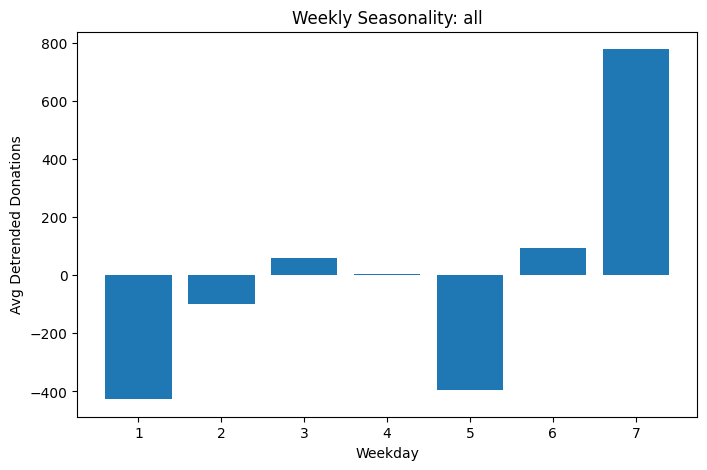

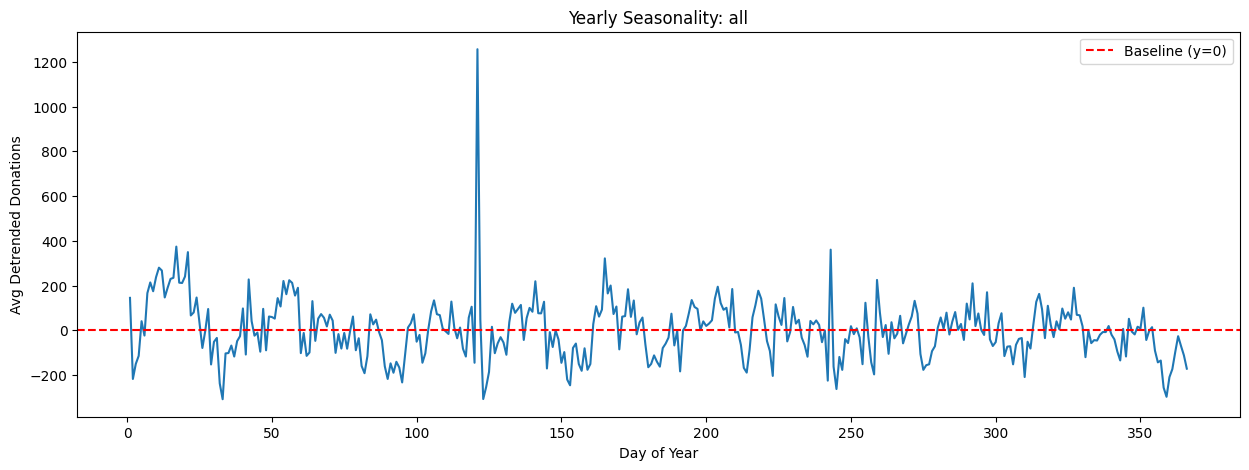

In [28]:
blood_type = 'all'


# Weekly seasonality
plt.figure(figsize=(8,5))
plt.bar(seasonality_by_weekday["weekday"].to_numpy(), seasonality_by_weekday[f"{blood_type}_avg_seasonality"].to_numpy())
plt.title(f"Weekly Seasonality: {blood_type}")
plt.xlabel("Weekday")
plt.ylabel("Avg Detrended Donations")
plt.show()

# Yearly seasonality
plt.figure(figsize=(15,5))
plt.plot(seasonality_by_dayofyear["day_of_year"].to_numpy(), seasonality_by_dayofyear[f"{blood_type}_avg_seasonality"].to_numpy())
plt.axhline(y=0, color='red', linestyle='--', label='Baseline (y=0)')
plt.title(f"Yearly Seasonality: {blood_type}")
plt.xlabel("Day of Year")
plt.ylabel("Avg Detrended Donations")
plt.legend()
plt.show()


In [29]:
spike_day = seasonality_by_dayofyear.sort("all_avg_seasonality", descending=True)

In [30]:
spike_day

day_of_year,all_avg_seasonality,a_avg_seasonality,b_avg_seasonality,ab_avg_seasonality,o_avg_seasonality
i16,f64,f64,f64,f64,f64
121,1256.174812,340.723684,305.87782,74.191729,535.381579
17,374.146617,88.526316,108.238722,23.37406,154.007519
243,360.528195,93.37782,81.890977,21.921053,163.338346
21,349.473684,76.701128,103.368421,21.191729,148.212406
165,321.56015,81.293233,91.486842,18.466165,130.31391
…,…,…,…,…,…
358,-256.291353,-66.156015,-70.695489,-15.148496,-104.291353
245,-262.257519,-66.071429,-73.426692,-16.697368,-106.06203
359,-297.048872,-69.340226,-84.87782,-19.280075,-123.550752


In [31]:
df_all.select("date", "all").sort("all", descending=True).head(10)

date,all
date,i64
2012-09-11,5543
2019-05-01,4684
2019-08-25,4516
2015-08-12,4359
2018-08-19,4283
2018-05-01,4193
2019-08-24,4188
2024-05-01,4047
2024-04-21,3996


In [32]:
# Anomaly Detection
from scipy.stats import zscore

In [33]:
# Calculate Z-scores for all columns
z_scores_all = zscore(df_all['all'].to_numpy())
z_scores_a = zscore(df_all['a'].to_numpy())
z_scores_b = zscore(df_all['b'].to_numpy())
z_scores_ab = zscore(df_all['ab'].to_numpy())
z_scores_o = zscore(df_all['o'].to_numpy())

df_all = df_all.with_columns(
    pl.Series(name='z_scores_all', values=z_scores_all),
    pl.Series(name='z_scores_a', values=z_scores_a),
    pl.Series(name='z_scores_b', values=z_scores_b),
    pl.Series(name='z_scores_ab', values=z_scores_ab),
    pl.Series(name='z_scores_o', values=z_scores_o)
)

threshold = 2.56
anomalies_all = df_all.filter((pl.col('z_scores_all') > threshold) | (pl.col('z_scores_all') < -threshold))
anomalies_a = df_all.filter((pl.col('z_scores_a') > threshold) | (pl.col('z_scores_a') < -threshold))
anomalies_b = df_all.filter((pl.col('z_scores_b') > threshold) | (pl.col('z_scores_b') < -threshold))
anomalies_ab = df_all.filter((pl.col('z_scores_ab') > threshold) | (pl.col('z_scores_ab') < -threshold))
anomalies_o = df_all.filter((pl.col('z_scores_o') > threshold) | (pl.col('z_scores_o') < -threshold))

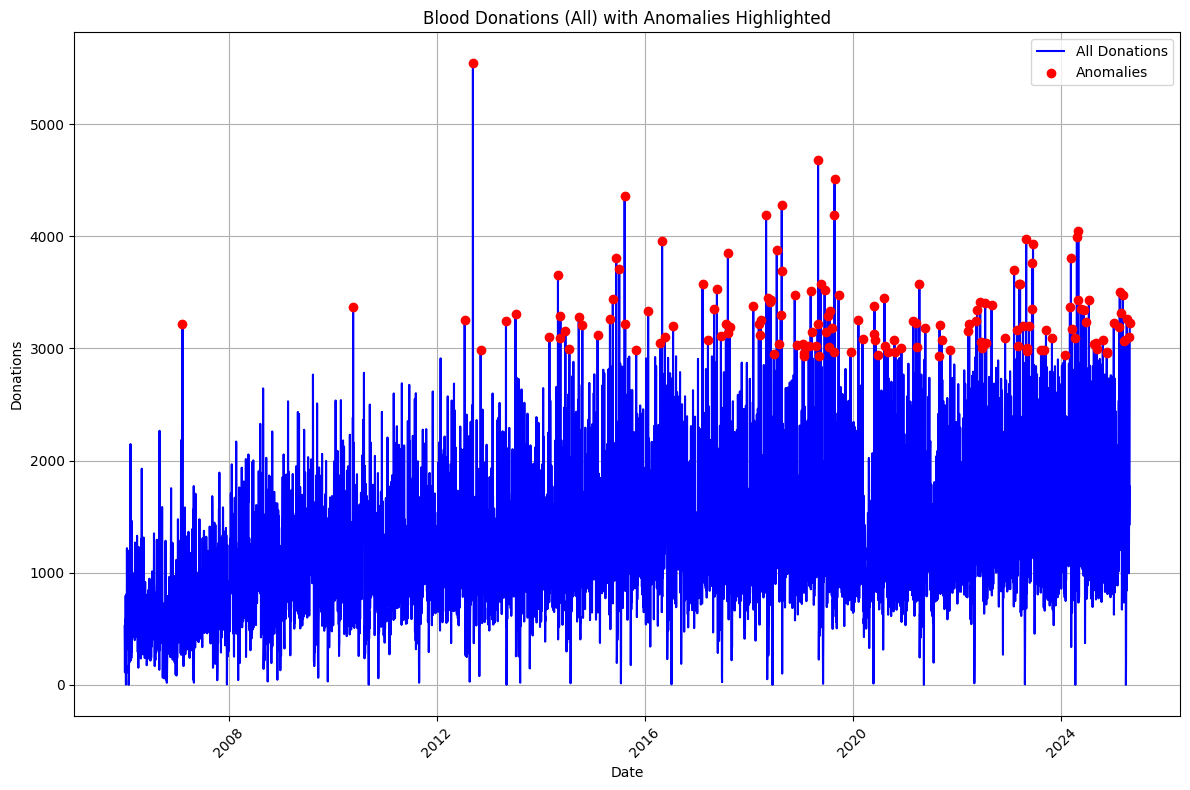

In [34]:
# Highlight anomalies on the 'all' column plot 
plt.figure(figsize=(12, 8))
plt.plot(df_all['date'], df_all['all'], label='All Donations', color='blue')
# Highlight anomalies on the 'all' column plot
plt.scatter(anomalies_all['date'], anomalies_all['all'], color='red', label='Anomalies', zorder=5)
plt.title('Blood Donations (All) with Anomalies Highlighted')
plt.xlabel('Date')
plt.ylabel('Donations')
plt.legend()
plt.grid()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

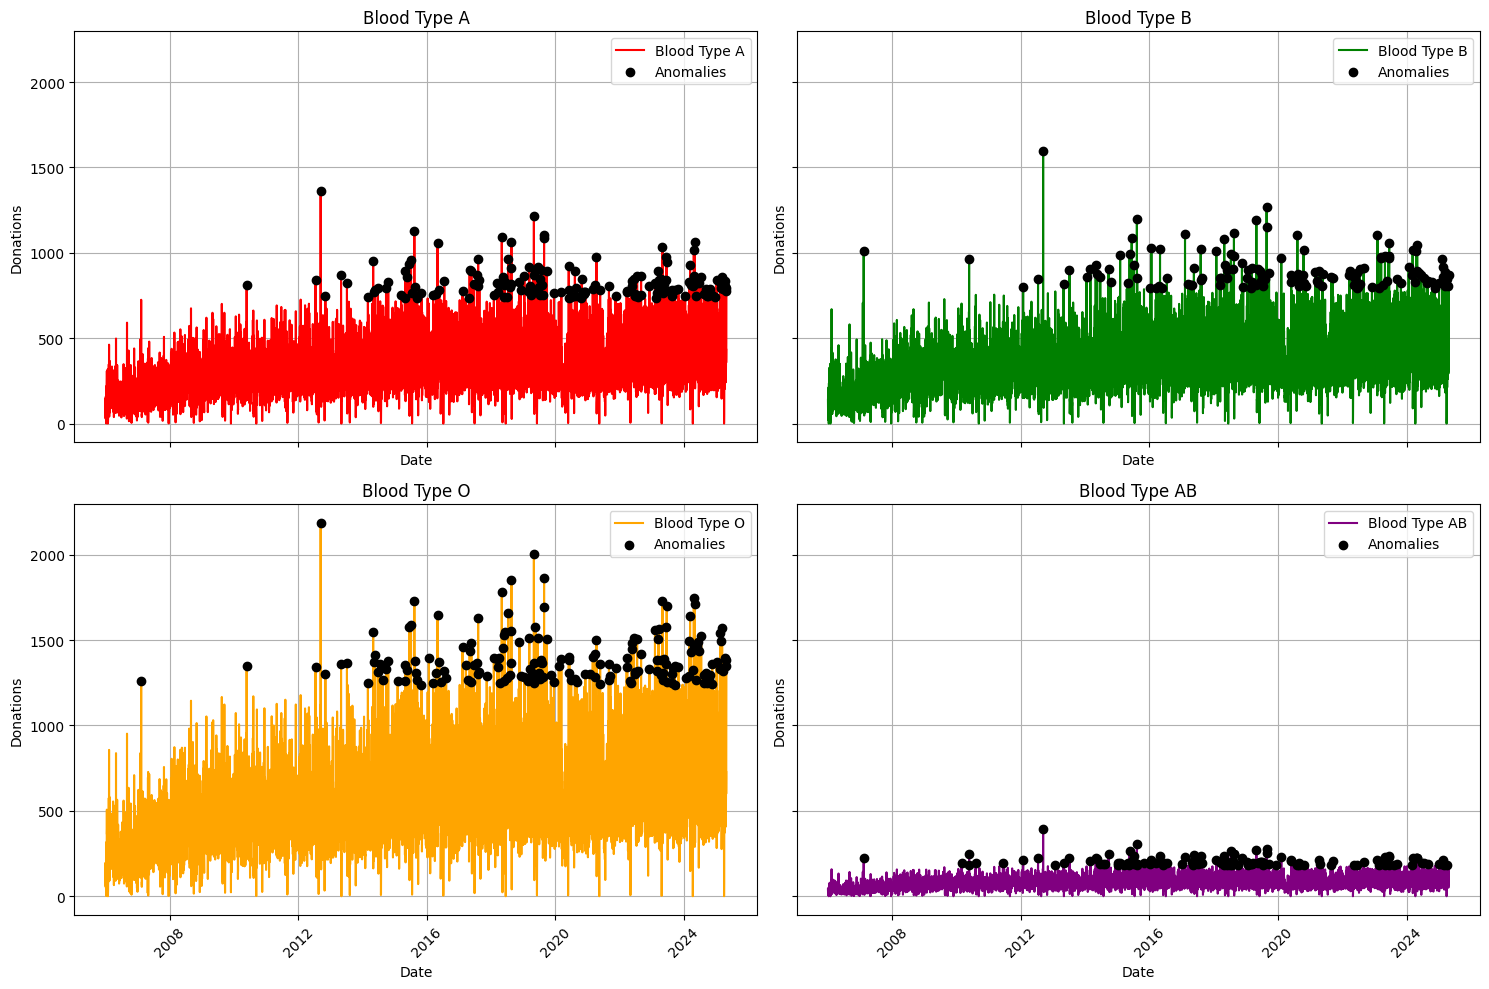

In [35]:
# 2x2 plot for 'a', 'b', 'o', and 'ab' columns with anomalies highlighted
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

columns = ['a', 'b', 'o', 'ab']
titles = ['Blood Type A', 'Blood Type B', 'Blood Type O', 'Blood Type AB']
colors = ['red', 'green', 'orange', 'purple']
anomalies = [anomalies_a, anomalies_b, anomalies_o, anomalies_ab]

for i, ax in enumerate(axes.flat):
    ax.plot(df_all['date'], df_all[columns[i]], label=titles[i], color=colors[i])
    ax.scatter(anomalies[i]['date'], anomalies[i][columns[i]], color='black', label='Anomalies', zorder=5)
    ax.set_title(titles[i])
    ax.set_xlabel('Date')
    ax.set_ylabel('Donations')
    ax.legend()
    ax.grid()

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [36]:
# We see some anomalies, but all on the higher side

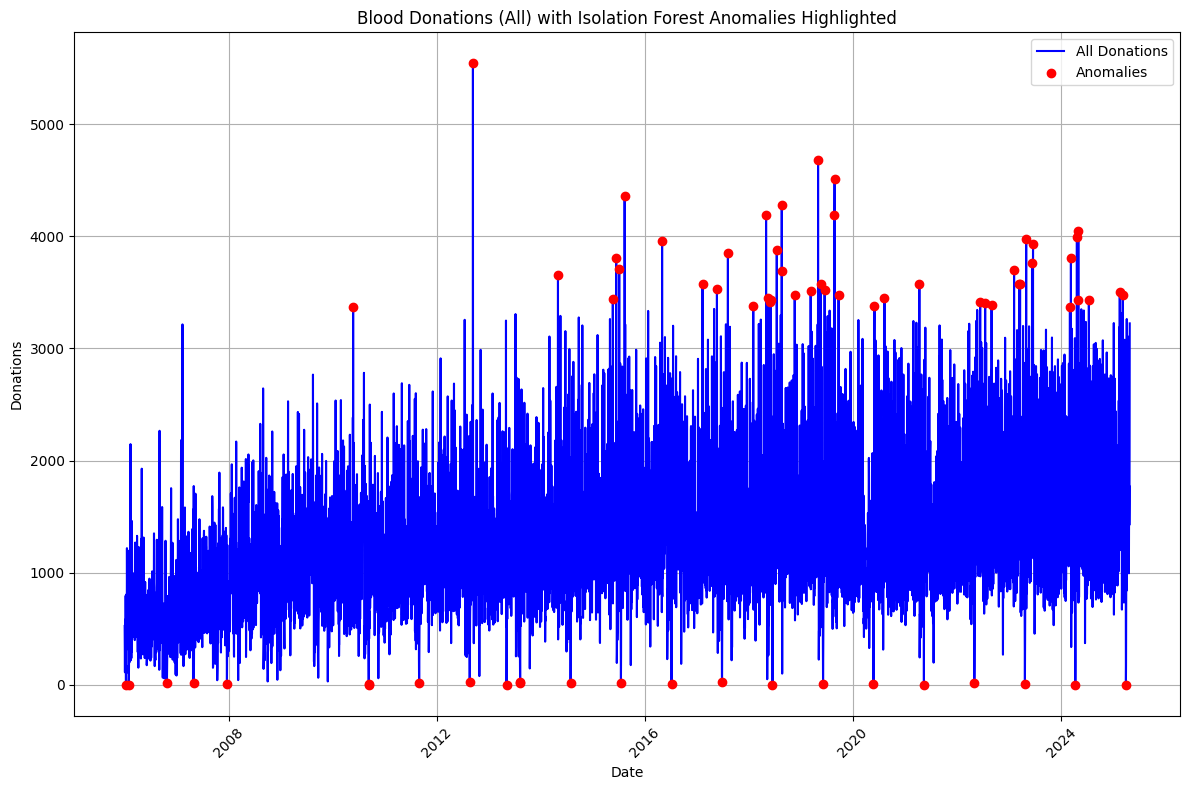

In [37]:
from sklearn.ensemble import IsolationForest

# Prepare the data for Isolation Forest
# We use the 'all' column as an example
X = df_all[['all']].to_numpy()

# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df_all = df_all.with_columns(
    pl.Series(name='iso_forest_anomaly', values=iso_forest.fit_predict(X))
)

# Filter anomalies
iso_anomalies = df_all.filter(pl.col('iso_forest_anomaly') == -1)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(df_all['date'], df_all['all'], label='All Donations', color='blue')
plt.scatter(iso_anomalies['date'], iso_anomalies['all'], color='red', label='Anomalies', zorder=5)
plt.title('Blood Donations (All) with Isolation Forest Anomalies Highlighted')
plt.xlabel('Date')
plt.ylabel('Donations')
plt.legend()
plt.grid()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
window_size=21

features = df_all.select([
    pl.col('all').rolling_mean(window_size).alias('mean'),
    pl.col('all').rolling_std(window_size).alias('std'),
    pl.col('all').rolling_max(window_size).alias('max'),
    pl.col('all').rolling_min(window_size).alias('min')
])

features = features.drop_nulls()
X = features.to_numpy()

model = IsolationForest(contamination='auto', random_state=42)

features = features.with_columns(
    pl.Series(name='iso_forest_anomaly', values=model.fit_predict(X)),
    pl.Series(name='date', values=df_all['date'][(window_size-1):])
)

In [39]:
iso_anomalies = features.filter(pl.col('iso_forest_anomaly') == -1)

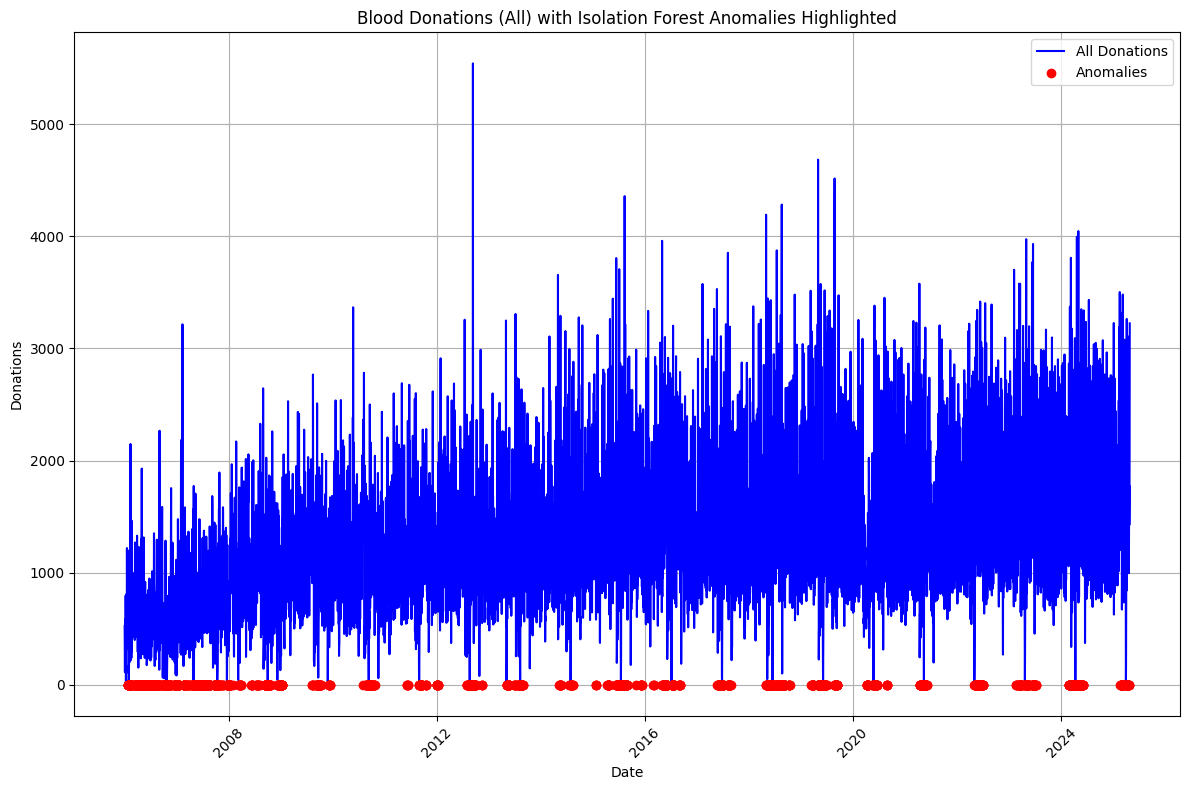

In [40]:


# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(df_all['date'], df_all['all'], label='All Donations', color='blue')
plt.scatter(iso_anomalies['date'], iso_anomalies['iso_forest_anomaly'], color='red', label='Anomalies', zorder=5)
plt.title('Blood Donations (All) with Isolation Forest Anomalies Highlighted')
plt.xlabel('Date')
plt.ylabel('Donations')
plt.legend()
plt.grid()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()